## Basic Settings

In [1]:
import sklearn as sk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
doc_path = "Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/"
working_path = "C:/Users/Jesper/Google Drive/Uni docs/Statistik/Machine Learning/project/"

## Loading the data
* Metainformatioon is provided in a seperate .csv file. The target Variable is "guten_genre"
* The documents are stored in a folder. They seem to be quite big when loaded in an sklearn dataset, so maybe we can not work with all the books stored in memory. 
* Alternatively we will have to pass filenames to some feature extraction method that will than return the extracted features.

In [3]:
meta = pd.read_csv(working_path+"Gutenberg_English_Fiction_1k/master996.csv", sep=";",
           header=0, encoding='latin1')

In [4]:
meta

,Book_Name,book_id,guten_genre,Author_Name
0,The Mystery of the Boule Cabinet: A Detective ...,pg10067.epub,Detective and Mystery,Stevenson| Burton Egbert
1,The Pupil,pg1032.epub,Literary,James| Henry
2,At Love's Cost,pg10379.epub,Literary,Garvice| Charles
3,The Heart of the Range,pg10473.epub,Western Stories,White| William Patterson
4,The Worshipper of the Image,pg10812.epub,Literary,Gallienne| Richard Le
...,...,...,...,...
991,David Copperfield,pg766DickensDavidCopfld.epub,Literary,Dickens| Charles
992,Hard Times,pg786DickensHardTimes.epub,Literary,Dickens| Charles
993,Memoirs of Shelock Holmes,pg834DoyleMemoirsSherlk.epub,Detective and Mystery,Connan| Doyle
994,The Mysterious Affair at Styles,pg863Agatha1.epub,Detective and Mystery,Christie| Agatha


In [88]:
#Extract target Variable and filenames
target = meta["guten_genre"]
book_id = meta["book_id"]
filenames = [working_path+doc_path+id.split(".")[0]+"-content.html" for id in book_id]
#There are two empty Documents (465, 622). those will be excluded.
filenames.pop(465)
filenames.pop(622)
len(filenames)

994

In [7]:
target.value_counts()
#The dataset is highly unbalanced, a classifier that only predicts
#"Literay" will get 79% Accuracy!

Literary                       794
Detective and Mystery          111
Sea and Adventure               36
Love and Romance                18
Western Stories                 18
Humorous and Wit and Satire      6
Ghost and Horror                 6
Christmas Stories                5
Allegories                       2
Name: guten_genre, dtype: int64

In [8]:
#Making train and test-dataset
from sklearn.model_selection import train_test_split
filenames_train, filenames_test, y_train, y_test = train_test_split(
                filenames, target, test_size=0.33)

In [9]:
#This will only work if "load_content=False". But its probably not usefull, 
#because it contains the files that are unlabelled.
#from sklearn import datasets
#data = datasets.load_files("Gutenberg_English_Fiction_1k/Gutenberg_English_Fiction_1k",
#                   shuffle=False, load_content=False)

## Train simple Bow model
* We will pass input=filename to the vectorizer. This will go through the files individually.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = CountVectorizer(input = "filename")
train_vectors = vectorizer.fit_transform(filenames_train)
test_vectors = vectorizer.transform(filenames_test)

In [11]:
vectorizer.vocabulary_

{'novel': 85784,
 'que': 100054,
 'voulez': 135904,
 'vous': 135916,
 'hélas': 61854,
 'notre': 85726,
 'mère': 83375,
 'nature': 83910,
 'comme': 26101,
 'toute': 126447,
 'autre': 9270,
 'ses': 111168,
 'enfants': 41631,
 'gâtés': 55893,
 'et': 43129,
 'pour': 96567,
 'les': 72229,
 'malvenus': 76248,
 'elle': 40740,
 'est': 43019,
 'avare': 9319,
 'dure': 39147,
 'london': 73973,
 'macmillan': 75431,
 'and': 5719,
 'co': 25126,
 '1884': 652,
 'the': 123930,
 'right': 105185,
 'of': 86745,
 'translation': 126941,
 'reproduction': 103797,
 'is': 66155,
 'reserved': 103974,
 'bungay': 18072,
 'dans': 32104,
 'air': 4128,
 'pâle': 99754,
 'émanant': 141507,
 'tranquilles': 126814,
 'lumières': 74796,
 'rayonnait': 101492,
 'astre': 8545,
 'or': 87686,
 'de': 32529,
 'arrière': 7817,
 'saison': 107582,
 'there': 124102,
 'was': 136778,
 'nothing': 85689,
 'remarkable': 103223,
 'in': 63126,
 'scene': 109059,
 'it': 66324,
 'just': 68091,
 'bit': 13924,
 'country': 29252,
 'lane': 70753,


In [12]:
#Importing model for classification (here Naive Bayes)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_vectors, y_train)
#Measuring accuracy on the training set
np.mean(nb.predict(train_vectors) == y_train)

0.9550224887556222

In [13]:
np.mean(nb.predict(test_vectors) == y_test)
#~10% Validation error! Only ~7% Above baseline this can be better!

0.8693009118541033

## How might we extract features?
* I want to illustrate how we could extract some features by only using the filenames. I will use the simplest possible feature: number of characters, which should indicate plot complexity to some extend.
* Also I think one possible workflow could be to split up the feature extraction by some theretical consideration (semantic vs. syntactic e.g.).

In [10]:
#Extract features takes a method (extractor) and filenames
#as argument and returns one feature. We could wrap this up by concatenating
#and just hand over a list of extracors to get our dataset ready.
def extract_feature(extractor, filenames):
    feature = []
    for filename in filenames:
        file = open(filename, "r", encoding="utf8")
        text = file.read()
        feature.append(extractor(text)) #type: String
        file.close()
    return(feature)

In [11]:
def extract_features(extractor_list, filenames):
    feature = [[]]
    for filename in filenames:
        file = open(filename, "r", encoding="utf8")
        text = file.read()
        text = word_tokenize(text)
        feature.append([extractor(text) for extractor in extractor_list]) #type: word_tokenizer
        file.close()
    return(feature)

## Extractors
(Put all Extractors here)

### Word and Sentence Statistics

In [11]:
word_length = extract_feature(len, filenames)

Text(0.5, 1.0, 'Histogramm Number of Characters in documents')

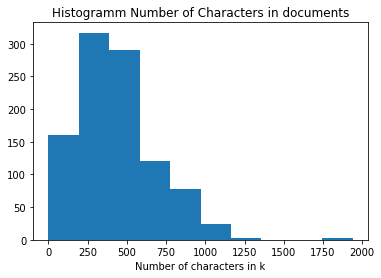

In [12]:
plt.hist(np.divide(np.asarray(word_length),1000))
plt.xlabel("Number of characters in k")
plt.title("Histogramm Number of Characters in documents")

In [101]:
#Now I use NLTK for the extraction of some simple feature
import nltk
from  nltk.sentiment.util import mark_negation
from nltk.tokenize import word_tokenize
from nltk import wordnet as wn
from nltk.corpus import sentiwordnet as swn
#nltk.download()

In [102]:
from nltk import word_tokenize
def n_words_extractor(text):
    return(len(word_tokenize(text)))

In [100]:
#This is kind of slow. Maybe we have to write a different wraper for extraction
#with NLTK.
word_count = extract_feature(n_words_extractor, filenames)

KeyboardInterrupt: 

In [ ]:
plt.hist(word_count)
plt.title("Histogramm Number of Words per Document")

### Sentiment Analysis
Fiction is very sentimental at times. So Sentiment might be a good Feature to extract in order to learn the Genre. For example Love and Romance storys are expected to have strong sentiments, as they normally include a lot of positive and negative feelings. Generally positive, negative and neutral Sentiment can be extracted, to give a more complex view on the feelings and opinions occuring in the Story. In order to extract Sentiment we will make some simplyfying assumtpions. Firstly we will assume, that sentiment can be measured on the word Level. So no structual information of any longer Sequences of Text will be used, apart from negations that will be assingend to all words in a sentence, following some negationing adjective. To achieve this nltk's toolkit for Sentiment analysis will be used[1]. In order to assign Sentiments to each word the sentiwordnet database will be used[2]. Here it will be assumed, that the sentiment of the most common usage of a word is sufficiant to derive overall sentiment. In order to keep it simple sentiment will only be derived from all nouns, verbs and adjectives and crunched in one number per dimension (positive, negative, neutral) by averaging over all sentences in the document. This might be very restrictive because some word-types might even out the sentiment of other word types, but it should still somehow measure the concept. Also the Average is only computed using half of the sentences of each Document for efficiency reasons. 


[1] nltk.sentiment.util.mark_negation(), version...
[2] sentiwordnet

In [105]:
example = open(filenames[0]).read()

In [106]:
from nltk.tokenize import word_tokenize
#sentences = example.split("\n")
#sentences = "".join(sentences)
sentences = example.split("<p>")
sentences = ". ".join(sentences)
sentences = nltk.sent_tokenize(sentences)
token_sentences = [word_tokenize(sentence) for sentence in sentences]
#Before all punctuation is gone: apply negations
token_sentences = [mark_negation(sentence) for sentence in token_sentences]
#Filter out punctuation
token_sentences = [[word for word in sentence if word.isalpha() or "_NEG" in word] for sentence in token_sentences]
#tok_example = word_tokenize(sentences)
token_sentences = list(filter(None, token_sentences))

In [107]:
sentences

['.',
 'A Detective Story\n.',
 'A.B.M.',
 'Fellow-Sherlockian\n.',
 '"Hello!"',
 "I said, as I took down the receiver of my desk 'phone, in answer to the call.",
 '.',
 '"Mr. Vantine wishes to speak to you, sir," said the office-boy.',
 '.',
 '"All right," and I heard the snap of the connection.',
 '.',
 '"Is that you, Lester?"',
 "asked Philip Vantine's voice.",
 '.',
 '"Yes.',
 'So you\'re back again?"',
 '.',
 '"Got in yesterday.',
 'Can you come up to the house and lunch with me to-day?"',
 '.',
 '"I\'ll be glad to," I said, and meant it, for I liked Philip Vantine.',
 '.',
 '"I\'ll look for you, then, about one-thirty."',
 '.',
 'And that is how it happened that, an hour later, I was walking over toward Washington Square, just above which, on the Avenue, the old Vantine mansion stood.',
 'It was almost the last survival of the old rÃ©gime; for the tide of business had long since overflowed from the neighbouring streets into the Avenue and swept its fashionable folk far uptown.',


In [108]:
print(swn.senti_synset('sadly.r.01'))

<sadly.r.01: PosScore=0.0 NegScore=0.625>


In [109]:
def get_senti_scores(tuple):
    typ = tuple[1]
    word = tuple[0]
    Negation = len(word.split("_"))
    word = word.split("_")[0]
    type_dict = {
        "VBB": "v",
        "VBG": "v",
        "VBN": "v",
        "VBP": "v",
        "VBZ": "v",
        "NN": "n",
        "NNS": "n",
        "NNP": "n",
        "NNPS": "n",
        "RB": "r",
        "RBR": "r",
        "RBS": "r",
        "JJ": "a",
        "JJR": "a",
        "JJS": "a",
    }
    typ = type_dict.get(typ)
    senti_res = [".",".","."]
    if(typ!=None):
        call_string = "{}.{}.01".format(word,typ)
        try:
            senti = swn.senti_synset(call_string)
            if(Negation==1):
                senti_res[0] = senti.pos_score()
                senti_res[1] = senti.neg_score()
                senti_res[2] = senti.obj_score()
            else:
                senti_res[1] = senti.pos_score()
                senti_res[0] = senti.neg_score()
                senti_res[2] = senti.obj_score()
        except:
            senti_res = [np.nan,np.nan,np.nan]
    return(senti_res)

In [110]:
print(get_senti_scores(("bad_NEG", "JJR")))

[0.625, 0.0, 0.375]


In [111]:
def get_sentence_sentiment(sentence, mean = True):
    sentence = nltk.pos_tag(sentence)
    sentiments = [get_senti_scores(word) for word in sentence]
    if(mean==True):
        sentiments = [sentiment for sentiment in sentiments if sentiment != [".",".","."]]
        mean = np.nanmean(np.asarray(sentiments), axis=0)
        #check wether type is none
        if(type(mean)==np.float64):
            return([np.nan,np.nan,np.nan])
        else:
            return(mean)#.tolist()
    return(sentiments)

In [112]:
sents = [get_sentence_sentiment(sentence) for sentence in token_sentences]

<ipython-input-111-0ef5e7fad8b8>:6: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(np.asarray(sentiments), axis=0)


In [114]:
np.nanmean(np.asarray(sents), axis = 0)

array([0.06955574, 0.0711447 , 0.85929956])

In [96]:
import random
def sentiment_extractor(document, keep=0.1):
    #Extract Sentences
    sentences = document.split("<p>")
    if len(sentences) <= 2:
        return([np.nan, np.nan, np.nan])
    sentences = ". ".join(sentences)
    sentences = nltk.sent_tokenize(sentences)
    sentences = random.sample(sentences, k = int(len(sentences)*0.5))
    token_sentences = [word_tokenize(sentence) for sentence in sentences]
    #Before all punctuation is gone: apply negations
    token_sentences = [mark_negation(sentence) for sentence in token_sentences]
    #Filter out punctuation
    token_sentences = [[word for word in sentence if word.isalpha() or "_NEG" in word] for sentence in token_sentences]
    #Remove Empty Senetnces
    token_sentences = list(filter(None, token_sentences))
    #Get Sentiments for all Sentences
    sents = [get_sentence_sentiment(sentence) for sentence in token_sentences]
    sents = np.asarray([sent for sent in sents])
    return(np.nanmean(sents, axis=0).tolist())

In [115]:
#This is just an emtpy document (465, 622)
sentiment_extractor(open(filenames[1]).read())

<ipython-input-111-0ef5e7fad8b8>:6: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(np.asarray(sentiments), axis=0)


[0.07678658352737872, 0.06384092806669685, 0.8593724884059247]

In [85]:
sentiment_features = extract_feature(sentiment_extractor, filenames)

<ipython-input-73-0ef5e7fad8b8>:6: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(np.asarray(sentiments), axis=0)
<ipython-input-79-b93df58fdd68>:18: RuntimeWarning: Mean of empty slice
  return(np.nanmean(sents, axis=0).tolist())


### Pronouns
Nowadays a lot of the Gender differences in interests are vanishing, but still there is some predictive power of gender for personal interests[1]. In the 19th Century this was propably also the case. Presumably correlation of gender and interests was even stronger, as Gender equality was not achieved to a high extend. So extracting Gender orientation of texts might be a valid approach to classify genre in our dataset. We assume that gender orientation can be measured by comparing the usage of gender-specific Pronouns. We will therefor simply count all the male and female-specific pronouns and derive two Features from that by dividing with the total Number of Words per Document. Dividing is necessary to avoid high correlation with Number of Words. The Extraction of These features is achieved by using simple nltk methods and pure Python. 


[source]

In [80]:
male_pronouns = ["he", "him", "his", "himself"]
female_pronouns = ["she", "her", "hers", "herself"]

In [81]:
from collections import Counter
def wordlist_frequency_extractor(document, wordlist, relative = False):
    document = document.split("<p>")
    document = ". ".join(document)
    words = word_tokenize(document)
    words = [word.lower() for word in words]
    words = [word for word in words if word.isalpha()]
    count_dict = Counter(words)
    freqs = [count_dict.get(key) for key in wordlist if key in words]
    if(relative == True):
        return(sum(freqs)/len(words))
    return(sum(freqs))

In [82]:
def female_pronoun_extractor(document):
    return(wordlist_frequency_extractor(document, female_pronouns))

In [83]:
def male_pronoun_extractor(document):
    return(wordlist_frequency_extractor(document, male_pronouns))

In [84]:
female_pronoun_freq = extract_feature(female_pronoun_extractor, filenames)

KeyboardInterrupt: 

In [ ]:
plt.hist(female_pronoun_freq)

In [138]:
male_pronoun_freq = extract_feature(male_pronoun_extractor, filenames)

In [120]:
sentiment_features = np.asarray(sentiment_features)
female_pronoun_freq = np.asarray(female_pronoun_freq)
male_pronoun_freq = np.asarray(male_pronoun_freq)
word_count = np.asarray(word_count)

data_ndarray = np.stack((female_pronoun_freq, male_pronoun_freq, word_count), axis = 1)
data_ndarray = np.concatenate((sentiment_features, data_ndarray), axis=1)

features = pd.DataFrame(data_ndarray, columns=["Positive Sentiment", "Negative Sentiment", "Objective Sentiment",
                                      "Female Orientation", "Male Orientation", "Number of words"])

NameError: name 'sentiment_features' is not defined

In [164]:
features = pd.read_csv("features_sentiment_pronouns.csv")

In [165]:
features["Female Orientation"] = features["Female Orientation"]/features["Number of words"]
features["Male Orientation"] = features["Male Orientation"]/features["Number of words"]

In [166]:
#features.to_csv("features_sentiment_pronouns.csv", index=False)
features

,Unnamed: 0,Positive Sentiment,Negative Sentiment,Objective Sentiment,Female Orientation,Male Orientation,Number of words
0,0,0.069640,0.071379,0.858981,0.003809,0.029175,93196.0
1,1,0.084249,0.073228,0.842523,0.009476,0.041080,21738.0
2,2,0.079357,0.081944,0.838699,0.024052,0.029611,194286.0
3,3,0.054528,0.064363,0.881109,0.006054,0.028418,125694.0
4,4,0.092752,0.090352,0.816896,0.020859,0.024122,22676.0
...,...,...,...,...,...,...,...
991,991,0.079843,0.078813,0.841344,0.014912,0.018668,452649.0
992,992,0.073225,0.077542,0.849233,0.015821,0.024473,132802.0
993,993,0.069468,0.071265,0.859267,0.004445,0.025997,110242.0
994,994,0.079316,0.091582,0.829102,0.012652,0.018398,80224.0


In [177]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#data = imp.fit_transform(data)
features = pd.DataFrame(imp.fit_transform(features), columns=["", "Positive Sentiment", "Negative Sentiment", "Objective Sentiment",
                                      "Female Orientation", "Male Orientation", "Number of words"])

## Exploratory Analysis

In [167]:
features.groupby(target).mean()

,Unnamed: 0,Positive Sentiment,Negative Sentiment,Objective Sentiment,Female Orientation,Male Orientation,Number of words
guten_genre,,,,,,,
Allegories,278.000000,0.079529,0.095361,0.825110,0.020235,0.027386,55752.000000
Christmas Stories,683.200000,0.072058,0.073919,0.854023,0.013606,0.025687,55664.800000
Detective and Mystery,565.621622,0.069593,0.077650,0.852757,0.011388,0.026932,90787.891892
Ghost and Horror,566.500000,0.080079,0.085085,0.834836,0.008125,0.030127,47447.333333
Humorous and Wit and Satire,695.500000,0.070323,0.073697,0.855980,0.011224,0.026506,98420.500000
Literary,481.205290,0.075672,0.082497,0.841831,0.017924,0.025939,100623.042821
Love and Romance,472.555556,0.080253,0.086279,0.833467,0.022217,0.023249,115127.722222
Sea and Adventure,580.611111,0.069183,0.076843,0.853973,0.010552,0.023705,106415.916667
Western Stories,538.722222,0.068724,0.075278,0.855999,0.007816,0.029848,94117.111111


### Sentiment
The derived Sentiment Features are in a range of really low values (between 0.0 and 0.2). This is due to the high number of words that don't have sentiment to them. Those words dominate the mean calculation. The standarddeviation is therefore also in a low order of magnitude (~0.01 for all three Features). It seems, that the differnces are not very big, and a rather low predictive Power is assumed. Observing the Histogramms, the Features seem to be normally distributed. If running an Anova, significant results for the Target variable are obtained. This means, that the means of the Sentiment variabes are dependent on the genre. To avoid completely imbalanced samples, the genres with less than 18 cases were comibined in to the genre "other" before running the anova. So the Sentiment Variables will be included in the final model. 

In [209]:
pd.DataFrame(features[["Positive Sentiment", "Negative Sentiment", "Objective Sentiment"]].describe())

,Positive Sentiment,Negative Sentiment,Objective Sentiment
count,996.000000,996.000000,996.000000
mean,0.074698,0.081633,0.843669
std,0.009238,0.011641,0.018070
min,0.041236,0.000000,0.782638
25%,0.068907,0.074314,0.832274
50%,0.074228,0.081351,0.844337
75%,0.079983,0.088800,0.855187
max,0.160599,0.117314,0.902951


Text(0.5, 1.0, 'Distribution of positive Sentiments')

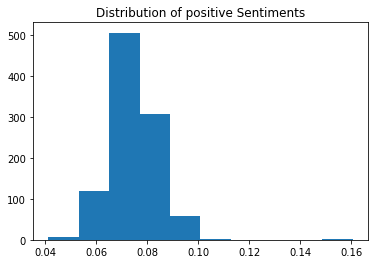

In [181]:
plt.hist(features["Positive Sentiment"])
plt.title("Distribution of positive Sentiments")

Text(0.5, 1.0, 'Distribution of Negative Sentiments')

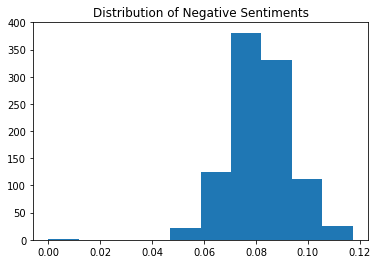

In [182]:
plt.hist(features["Negative Sentiment"])
plt.title("Distribution of Negative Sentiments")

In [196]:
target_red = pd.DataFrame(target.copy())
target_red = target_red.replace(to_replace=["Allegories", "Ghost and Horror", "Christmas Stories",
                              "Humorous and Wit and Satire"], value="other")
target_red.guten_genre.value_counts()

Literary                 794
Detective and Mystery    111
Sea and Adventure         36
other                     19
Love and Romance          18
Western Stories           18
Name: guten_genre, dtype: int64

In [198]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
target_int = LE.fit_transform(target_red.guten_genre)
anova = f_classif(features[["Positive Sentiment", "Negative Sentiment", "Objective Sentiment"]], target_int)

In [199]:
anova

(array([14.87755455,  6.62597953, 13.21509951]),
 array([4.25459364e-14, 4.44283932e-06, 1.75537821e-12]))

### Pronouns
The summary statistics for Gender-Orientation confirm some previous Hypothesis. The mean male orientation is higher than the mean female orientation, but at the same time the variance is higher for female orientation. We can see, in the Histogramms, that the Distribution for Male Orientaion seems gaussian, while Female Orientation has a longer tail on the right sight. Some Documents must be highly female oriented, while in other documents females are rare. Male orientation is on a steady high level. The Anova confirms that female orientation has a high predictive power for the genre, while male orintation doesn't. 

In [202]:
pd.DataFrame(features[["Female Orientation", "Male Orientation"]].describe())

,Female Orientation,Male Orientation
count,996.000000,996.000000
mean,0.016705,0.026022
std,0.009509,0.008420
min,0.000000,0.000000
25%,0.009143,0.020282
50%,0.015660,0.025863
75%,0.022999,0.030893
max,0.051899,0.059989


Text(0.5, 1.0, 'Distribution of relative Female Pronoun Frequencies')

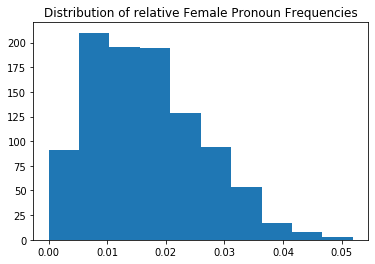

In [203]:
plt.hist(features["Female Orientation"])
plt.title("Distribution of relative Female Pronoun Frequencies")

Text(0.5, 1.0, 'Histogramm male Pronoun Frequencies')

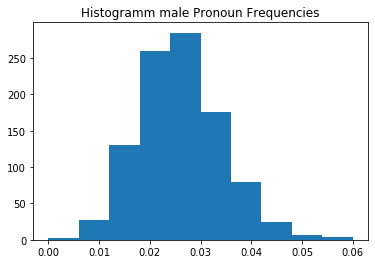

In [204]:
plt.hist(features["Male Orientation"]) 
plt.title("Histogramm male Pronoun Frequencies")

In [205]:
anova = f_classif(features[["Female Orientation", "Male Orientation"]], target_int)

In [206]:
anova

(array([19.58303556,  2.08660125]), array([1.22852991e-18, 6.48079090e-02]))

## Model training

In [210]:
data = features.copy()

In [211]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data = pd.DataFrame(min_max_scaler.fit_transform(data))

In [212]:
#Making train and test-dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
                data, target, test_size=0.33)

In [213]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [214]:
lreg = LogisticRegression(max_iter=10000)
nb = GaussianNB()

In [215]:
lreg.fit(x_train, y_train)
nb.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [216]:
np.mean(nb.predict(x_test) == y_test)

0.7142857142857143

In [217]:
np.mean(lreg.predict(x_test) == y_test)
#It just predicts Literary all the time so I think the nb is closer to reallity

0.7689969604863222